# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera Calibration / Image Undistortion

For additional info see "./camera_cal/CameraCalibrationImageUndistortionNotebook.ipynb"

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

def calibrate_and_undistort(fname, nx=9, ny=6):
    objpoints = []
    imagepoints = []
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        imagepoints.append(corners)
        objpoints.append(objp)
        #   cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imagepoints, gray.shape[::-1], None, None)
        return cv2.undistort(img, mtx, dist, None, mtx)
    else:
        return None

### Applied on an example:

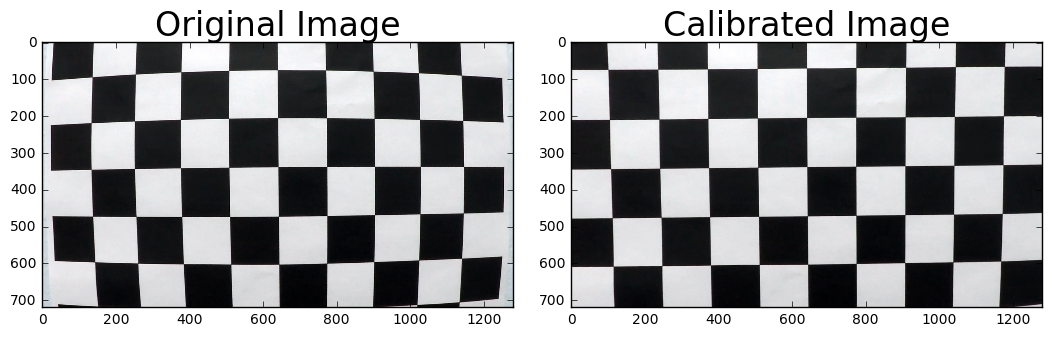

In [3]:
example_image = "./camera_cal/calibration1.jpg"
oimg = cv2.imread(example_image)
cimg = calibrate_and_undistort(example_image, 9, 5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax1.imshow(oimg)
ax1.set_title('Original Image', fontsize=24)
ax2.imshow(cimg)
ax2.set_title('Calibrated Image', fontsize=24)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Thresholded Binary Image